First, we mount google drive and import the required tools.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import io
import pylab as plt
import numpy as np
import plotly.express as px
from datetime import datetime, timedelta
import plotly.graph_objects as go
from scipy.optimize import curve_fit

solar_colour = '#e05904'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create a plot of average daily solar irradiance on a month-by-month basis.


The "filename" line will need to be amended to find the data in your google drive. The csv filename must be in the format from CEDA such that the file can be found as the year value changes.

In [14]:
#Creates the list of years we want to examine
years_list = list(range(2005,2020))

#Creates a list of the dataframes for each year by using a loop. Process these dataframes and add them to the list "frame"
frame = []
for Year in years_list:
  filename = f'/content/drive/MyDrive/CP540 Data/Auchincruive Radiation 2005-2020/midas-open_uk-radiation-obs_dv-202107_ayrshire_01005_auchincruive_qcv-1_{Year}.csv'
  df = pd.read_csv(filename, skiprows=[*range(75)], skipinitialspace=True)
  df = df.drop(df.columns[[1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]], axis=1)
  df = df.drop(df.tail(1).index, axis = 0)
  df['ob_end_time'] = pd.to_datetime(df.ob_end_time, format='%Y/%m/%d %H:%M:%S')
  df.dropna()
  df = df[df.ob_hour_count == 1] #Only use values with an hour count of 1, there are a few daily values present
  df = df.sort_values('ob_end_time', ascending=True)
  df['timestamp'] = df['ob_end_time'].dt.strftime('%m/%Y')
  frame.append(df)

#Create a single dataframe for all years by combining the dataframes in "Frame"
Comb2 = pd.concat(frame)

#Provide a list of dates which can be used for plots and finding average irradiance. We can vary the "freq=" value to add datapoints to the graph. Note: we may need to change the date format
spread = pd.date_range(f'2005-07-19',f'2019-12-31', freq='M').strftime("%m/%Y").tolist()

#Create empty list for average irradiance within a timeframe
avgq = []
for i in spread:
  avgq.append((Comb2.loc[Comb2['timestamp'] == i, 'glbl_irad_amt'].mean()))


#Create the plot and format as desired
plotdf = pd.DataFrame({'spread':spread, 'Daily Average Solar Irradiance':avgq})
fig = px.bar(plotdf, x='spread', y='Daily Average Solar Irradiance', color_discrete_sequence=[solar_colour])
fig.update_layout(yaxis_title='Solar Irradiance // W/m2', xaxis_title='Month', title='Average Daily Solar Irradiance')
fig.show()

Input battery sizes and costs, and fit a line of best fit to obtain an equation to estimate cost

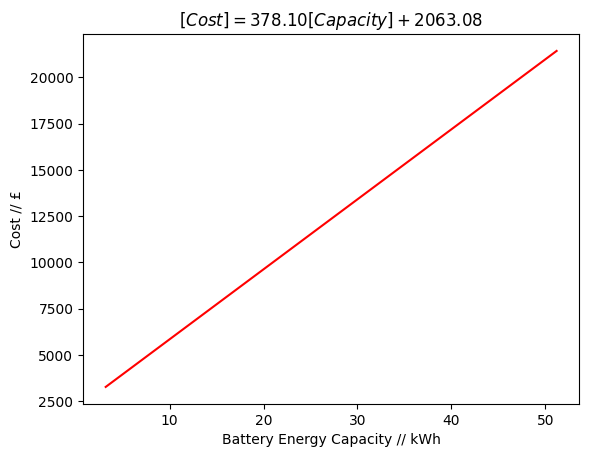

In [15]:
#Cost Curve for https://lr-renewables.co.uk/product-category/battery-systems/ Lux + Greenlinx Storage

#Input battery data
battery_data = {
  "Energy": [51.2, 44.8, 38.4, 32, 25.6, 22.4, 19.2, 16, 12.8, 9.6, 6.4, 3.2],
  "Cost": [21300, 19000, 16700, 14400, 11590, 10390, 9190, 7990, 7500, 5590, 4390, 3190]
}

#Create a dataframe for the battery data
battery_columns = ["Energy", "Cost"]
batterydf = pd.DataFrame(battery_data, columns=battery_columns)

#Specify the form of the line of best fit equation
def linear_function(x, a, b):
    return a * x + b

#Fit the linear function to the data
params, covariance = curve_fit(linear_function, batterydf['Energy'], batterydf['Cost'])

#Extract the slope and intercept from the fitting
slope, intercept = params

#Calculate the trendline values
trendline = linear_function(batterydf['Energy'], slope, intercept)

#Plot the best fit line and display the equation as the title
plt.plot(batterydf['Energy'], trendline, color='red', label='Trendline')
plt.xlabel('Battery Energy Capacity // kWh')
plt.ylabel('Cost // £')
plt.title(f'$[Cost] = {slope:.2f} [Capacity] + {intercept:.2f}$');

Create plot of required battery capacity against panel area

In [16]:
#Specify an initial battery size and a range of panel areas
Battery_size = 22.4  # kWh
areas = [50, 70, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 150, 160, 175, 200, 225, 250, 300, 400] #m2

# Create an empty list to store minimum values
min_energy_values = []

#Loop for areas provided
for Area in areas:
    df2 = pd.DataFrame({'datetime': Comb2['ob_end_time'],
                        'radiation': Comb2['glbl_irad_amt']})

    df2['datetime'] = pd.to_datetime(df2.datetime, format='%Y/%m/%d %H:%M:%S')
    df2.dropna(subset=['radiation'], inplace=True)

    #Loop for each irradiance value in the dataframe
    energy = [Battery_size]
    for i in range(1, len(df2)):
        #Calculate the new stored energy value based on the previous value
        new_volume = energy[i - 1] - 0.57 + df2['radiation'].iloc[i - 1] * Area * 3600 * 0.15 / (3.6 * 10**6)

        #If the calculated stored energy value is greater than the battery capacity, replace the new value with the maximum stored energy for the battery
        if new_volume > energy[0]:
            new_volume = energy[0]
        energy.append(new_volume)

    #Find the minimum stored energy value and append the list
    min_energy = min(energy)
    min_energy_values.append(min_energy)

#Calculate the required battery size to ensure there is always sufficient stored energy
battery_sizes = [Battery_size - value for value in min_energy_values]

#Create the plot
figba = px.line(x=areas, y=battery_sizes, color_discrete_sequence=[solar_colour]) #Create a figure
figba.update_layout(yaxis_title='Battery Size // kWh', xaxis_title='Panel Area // m2', title='Battery Size Required For Varying Panel Areas') #Add titles
figba.show()

Create a cost optimisation curve based on the investment of the solar panels and battery size

In [17]:
#Create a dataframe from the previous data
df3 = pd.DataFrame({'Area':areas, 'Battery':battery_sizes})

#From https://www.solarguide.co.uk/how-much-does-it-cost-to-install-solar-panels#/, the cost per m2 of solar panels is estimated. Based on an efficiency of 15%, it is assumed Polycrystalline panels are used
cpsqm = 250 #£/m2

#Create the 'cost' column based on the battery cost and cost per area of solar panels
df3['cost'] = df3['Battery']*slope + intercept + df3['Area']*cpsqm

#Plot data
plotdf3 = pd.DataFrame({'Area':df3['Area'], 'Cost':df3['cost']})
figdf3 = px.line(plotdf3, x='Area', y='Cost', color_discrete_sequence=[solar_colour]) #Create a figure
figdf3.update_layout(yaxis_title='Total Investment // £', xaxis_title='Panel Area // m2', title='Total Investment of Battery and Panels for Varying Panel Areas') #Add titles
figdf3.show()

From the above plot, input the battery size and panel area to plot the amount of stored energy on an hourly basis. This assumes that power usage is constant throughout the year

In [18]:
#From the optimised curve, specify the panel area and battery size values
Battery_size = 33 #kWh
Area = 130 #m2

#Create the dataframe and format
df4 = pd.DataFrame({'datetime':Comb2['ob_end_time'],
                    'radiation':Comb2['glbl_irad_amt']
                    })


df4['datetime'] = pd.to_datetime(df4.datetime, format='%Y/%m/%d %H:%M:%S')
df4.dropna(subset=['radiation'], inplace=True)

#Starting at a fully charger battery, calculate the stored energy at the end of each hour accounting for collection, energy use, and initial stored energy
E = [Battery_size]
for i in range(1, len(df2)):
    # Calculate the new stored energy value based on the previous hour's value
    new_E = E[i-1] - 0.57 + df4['radiation'].iloc[i-1]*Area*3600*0.15/(3.6*10**6)
    if new_E > E[0]:
      new_E = E[0]
    E.append(new_E)

#Create plot
plotdf4 = pd.DataFrame({'datetime':df4['datetime'], 'radiation':df4['radiation']})
figdf4 = px.line(plotdf4, x=df4['datetime'], y=E, color_discrete_sequence=[solar_colour])
figdf4.update_layout(yaxis_title='Stored Energy // kWh', xaxis_title='Date', title='Stored Energy in Batteries For The 15 Year Period')
figdf4.show()